# Part 2: LSGAN

https://github.com/begraiPB/Data255DeepLearning/blob/main/Assignment5_Part2_LSGAN.ipynb

### LSGAN Changes:

1. We need to change the loss function from binary cross-entropy loss (BCE) to least squares loss for both the discriminator and the generator.
2. The discriminator's output should not have any activation function applied since the least squares loss is computed on the raw output of the discriminator.

## Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.



In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
                              train=True,
                              download=True,
                              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [2]:
img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


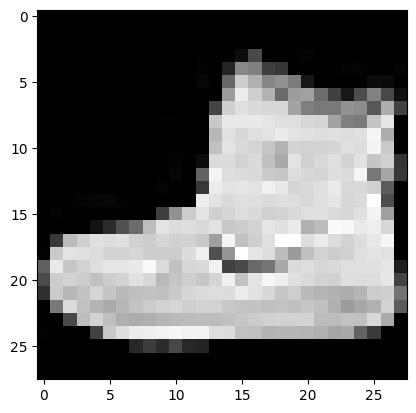

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([9, 9, 9, 1, 6, 7, 7, 6, 1, 3, 7, 2, 2, 9, 1, 4, 2, 0, 2, 2, 5, 9, 3, 5,
        1, 6, 0, 7, 4, 2, 0, 4, 8, 1, 8, 2, 4, 1, 6, 3, 8, 6, 6, 5, 4, 1, 2, 8,
        6, 4, 7, 9, 5, 1, 7, 9, 1, 1, 9, 2, 2, 1, 1, 8, 1, 4, 7, 8, 1, 3, 4, 9,
        1, 6, 8, 3, 9, 8, 8, 3, 2, 2, 2, 5, 5, 2, 8, 9, 3, 1, 2, 7, 3, 6, 3, 9,
        4, 3, 9, 2])


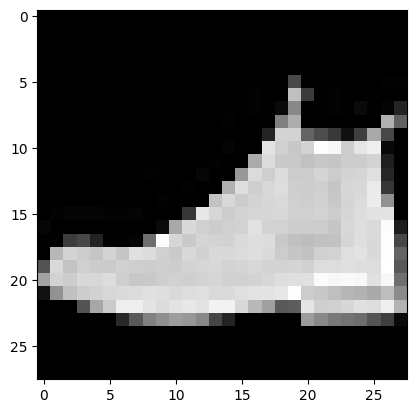

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

## Discriminator Network

In [9]:
image_size = 784
hidden_size = 256

In [10]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1))

In [11]:
D.to(device);

## Generator Network

In [12]:
latent_size = 64

In [13]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [14]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

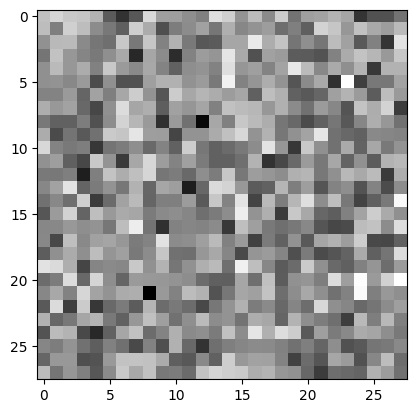

In [15]:
plt.imshow(gen_imgs[0], cmap='gray');

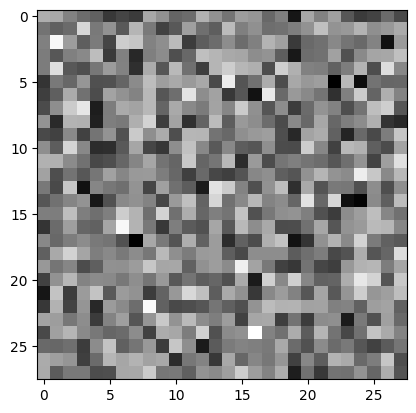

In [16]:
plt.imshow(gen_imgs[1], cmap='gray');

In [17]:
G.to(device);

## Discriminator Training


LSGAN Changes:
1. We need to change the loss function from binary cross-entropy loss (BCE) to least squares loss for both the discriminator and the generator
2. The discriminator's output should not have any activation function applied since the least squares loss is computed on the raw output of the discriminator.

In [18]:
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [19]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

## Generator Training

In [20]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [21]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## Training the Model


In [22]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

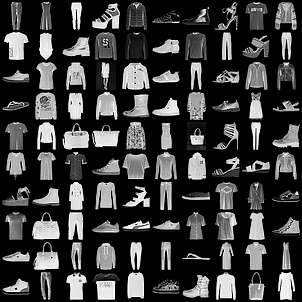

In [23]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


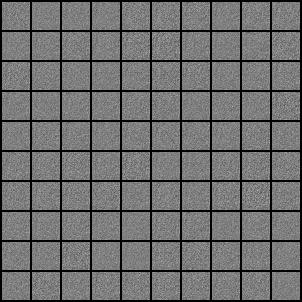

In [24]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

## Step2. Train the GAN model to produce images in this new domain.

In [25]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0050, g_loss: 1.1682, D(x): 0.99, D(G(z)): 0.00
Epoch [0/300], Step [400/600], d_loss: 0.0134, g_loss: 1.3550, D(x): 1.01, D(G(z)): 0.05
Epoch [0/300], Step [600/600], d_loss: 0.0082, g_loss: 1.1353, D(x): 0.99, D(G(z)): -0.01
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0078, g_loss: 1.0756, D(x): 1.00, D(G(z)): 0.03
Epoch [1/300], Step [400/600], d_loss: 0.0033, g_loss: 1.1326, D(x): 1.00, D(G(z)): -0.01
Epoch [1/300], Step [600/600], d_loss: 0.0030, g_loss: 1.0359, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0054, g_loss: 1.1413, D(x): 1.01, D(G(z)): 0.01
Epoch [2/300], Step [400/600], d_loss: 0.0050, g_loss: 0.9772, D(x): 0.98, D(G(z)): -0.03
Epoch [2/300], Step [600/600], d_loss: 0.0108, g_loss: 1.3122, D(x): 0.99, D(G(z)): 0.06
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0094, g_loss: 1.0616, D(x): 0.97, D(G(z)): -0.01
Epoch [3/300], Step [4

## Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

No difficulty faced here,

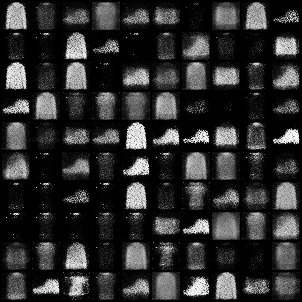

In [26]:
Image('./samples/fake_images-0010.png')

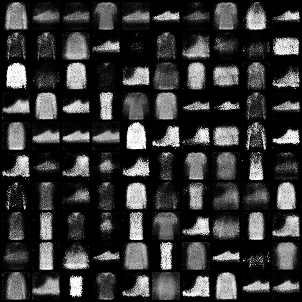

In [27]:
Image('./samples/fake_images-0020.png')

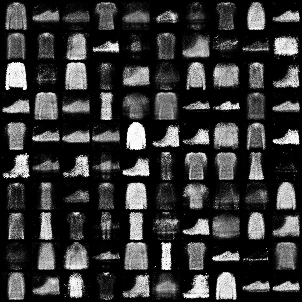

In [28]:
Image('./samples/fake_images-0030.png')

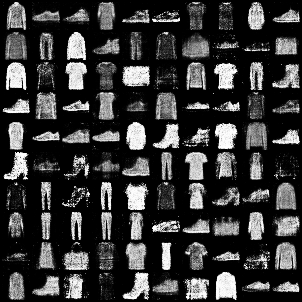

In [48]:
Image('./samples/fake_images-0101.png')

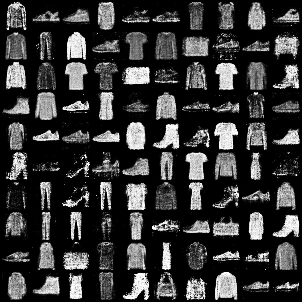

In [49]:
Image('./samples/fake_images-0200.png')

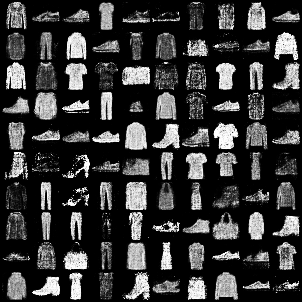

In [50]:
Image('./samples/fake_images-0300.png')

## Step4. Save the model weights in the folder to be used later.

In [32]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [33]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

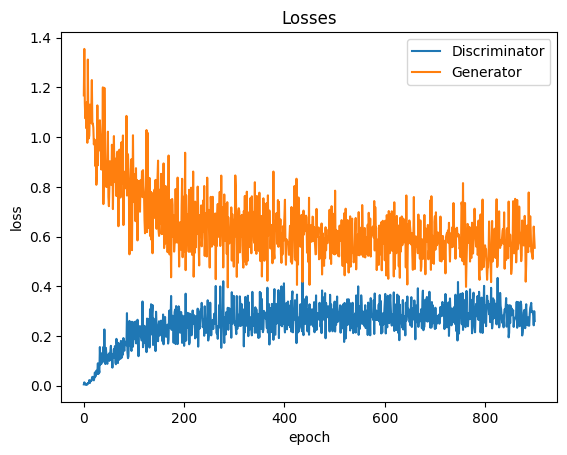

In [34]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

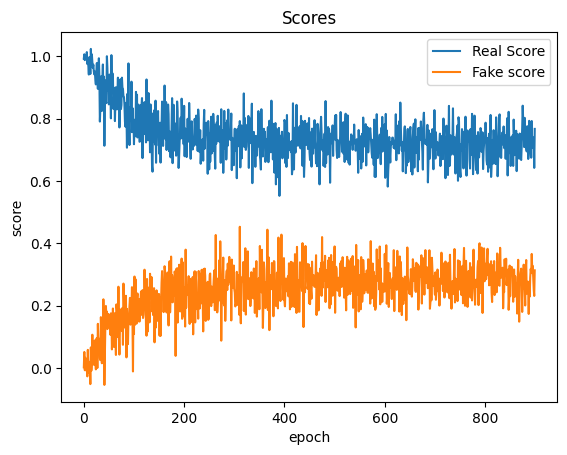

In [35]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

## Step5. Load the model using the saved weights.

In [36]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [37]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [38]:
D.load_state_dict(torch.load('D.ckpt'))
G.load_state_dict(torch.load('G.ckpt'))


<All keys matched successfully>

In [51]:
D.to(device);
G.to(device);

In [52]:
%%time

num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/50], Step [200/600], d_loss: 0.4417, g_loss: 0.1757, D(x): 0.67, D(G(z)): 0.57
Epoch [0/50], Step [400/600], d_loss: 0.4445, g_loss: 0.1892, D(x): 0.67, D(G(z)): 0.57
Epoch [0/50], Step [600/600], d_loss: 0.4486, g_loss: 0.1902, D(x): 0.67, D(G(z)): 0.58
Saving fake_images-0001.png
Epoch [1/50], Step [200/600], d_loss: 0.4382, g_loss: 0.1879, D(x): 0.68, D(G(z)): 0.57
Epoch [1/50], Step [400/600], d_loss: 0.4390, g_loss: 0.1924, D(x): 0.66, D(G(z)): 0.57
Epoch [1/50], Step [600/600], d_loss: 0.4401, g_loss: 0.1819, D(x): 0.67, D(G(z)): 0.57
Saving fake_images-0002.png
Epoch [2/50], Step [200/600], d_loss: 0.4456, g_loss: 0.1867, D(x): 0.67, D(G(z)): 0.58
Epoch [2/50], Step [400/600], d_loss: 0.4468, g_loss: 0.1876, D(x): 0.67, D(G(z)): 0.58
Epoch [2/50], Step [600/600], d_loss: 0.4368, g_loss: 0.1811, D(x): 0.66, D(G(z)): 0.56
Saving fake_images-0003.png
Epoch [3/50], Step [200/600], d_loss: 0.4401, g_loss: 0.1831, D(x): 0.67, D(G(z)): 0.57
Epoch [3/50], Step [400/600], d_loss

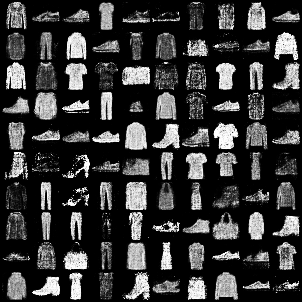

In [53]:
Image('./samples/fake_images-0001.png')

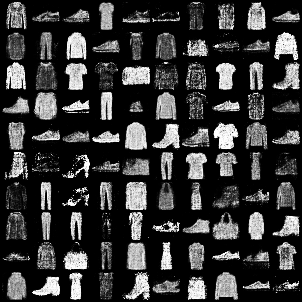

In [54]:
Image('./samples/fake_images-0049.png')

In [55]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

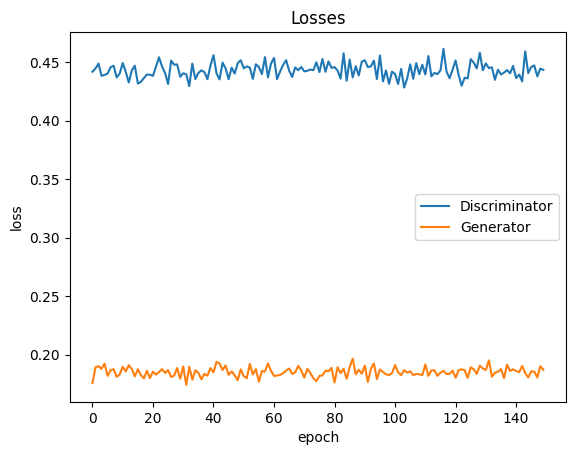

In [56]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

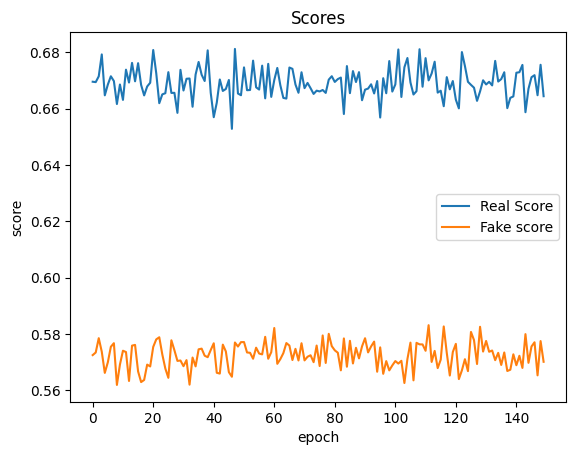

In [57]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

## Step 7: Save the model weights without using checkpoints.

In [58]:
torch.save(D, 'D_without_checkpoint.model')
torch.save(G, 'G_without_checkpoint.model')


## Step 8: Load the model weights without using checkpoints.

In [59]:
D = torch.load('D_without_checkpoint.model')
G = torch.load('G_without_checkpoint.model')

With LS-GAN, we saw improved performance sooner, compared to GAN.

However, regarding the performance of the models, inferred from the Real and Fake scores, the GAN model fared better.